In [80]:
import os, sys, glob, argparse
import pandas as pd
import numpy as np
from tqdm import tqdm

import time, datetime
import pdb, traceback
import cv2
# import imagehash
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b4') 

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

import matplotlib.pyplot as plt

In [72]:
class QRDataset(Dataset):
    
    def __init__(self, img_path,transform = None):
        
        self.img_path = img_path
        
        if transform is not None:
            self.transform = transform
            
        else:
            self.transform = None
    
    def __getitem__(self, index):
        start_time = time.time()
        img = Image.open(self.img_path[index]).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        return img, torch.from_numpy(np.array(int('PNEUMONIA' in self.img_path[index])))
    
    def __len__(self):
        return len(self.img_path)

class VisitNet(nn.Module):
    def __init__(self):
        super(VisitNet, self).__init__()
        
        model = models.resnet18(True)
        model.avgpool = nn.AdaptiveAvgPool2d(1)
        model.fc = nn.Linear(512,2)
        self.resnet = model
        
#         model = EfficientNet.from_pretrained('efficientnet-b4') 
#         model._fc = nn.Linear(1792, 2)
#         self.resnet = model

    def forward(self,img):
        out = self.resnet(img)
        return out
        
def predict(test_loader, model, tta = 10):
    
    #switch to evaluate mode
    #变为评估模式
    
    model.eval()
    
    test_pred_tta = None
    for _ in range(tta):
        test_pred =[]
        with torch.no_grad():
            end = time.time()
            for i, (input, target) in enumerate(test_loader):
                input = input.cuda()
                target = target.cuda()
                
                # 计算输出
                output = model(input)
                output = output.data.cpu().numpy()
                
                test_pred.append(output)
                
        test_pred = np.vstack(test_pred)
        
        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred
            
    return test_pred_tta


test_jpg = ['test/{0}.jpg'.format(x) for x in range(0, 1047)]
test_jpg = np.array(test_jpg)

test_pred = None

for model_path in ['resnet18_fold0.pt', 'resnet18_fold1.pt', 'resnet18_fold2.pt',
                  'resnet18_fold3.pt', 'resnet18_fold4.pt', 'resnet18_fold5.pt',
                  'resnet18_fold6.pt', 'resnet18_fold7.pt', 'resnet18_fold8.pt',
                  'resnet18_fold9.pt']:
    
    test_loader = torch.utils.data.DataLoader(
        QRDataset(test_jpg,
                transforms.Compose([
                            transforms.Resize((512, 512)),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        ), batch_size=10, shuffle=False, num_workers=0, pin_memory=True)
        
    model = VisitNet().cuda()
    model.load_state_dict(torch.load(model_path))
    
    if test_pred is None:
        test_pred = predict(test_loader, model, 2)
    else:
        test_pred += predict(test_loader, model, 2)

test_csv = pd.DataFrame()
test_csv[0] = list(range(0, 1047))
test_csv[1] = np.argmax(test_pred, 1)
test_csv.to_csv('train_predict.csv', index=None, header=None)

In [70]:
train_data = pd.read_csv('train.csv')
train_predict = pd.read_csv('train_predict.csv')

corrected_predicted = 0
for i in range(train_predict.shape[0]):
    
    if train_data.iloc[i][1] == train_predict.iloc[i][1]:
        corrected_predicted += 1
    else:
        continue

        
    

In [71]:
print('accuracy: ', corrected_predicted,'/',train_predict.shape[0])

accuracy:  1046 / 1046


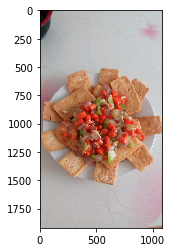

In [81]:
img = Image.open(test_jpg[0])
plt.figure()
plt.imshow(img)